In [1]:
import numpy as np

x = np.load("/project/msoleyma_1026/ecp-cause-pair/pair_embeddings/video-train/conv_18_utterance_pair_9_2.npy")
print(x.shape)

(2, 768)


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import sklearn; print(sklearn.__version__)

1.2.2


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import json
from torch.utils.data import DataLoader, Dataset
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import os
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [5]:
with open('/project/msoleyma_1026/ecp/data/utterance_pairs_emotion_flags_train.json', 'r') as f:
    data = json.load(f)

In [6]:
class_one_count = 0
class_zero_count = 0
for conv in data:
    for key, value in conv.items():
        for utterance_pair in value:
            if utterance_pair['valid_pair'] == 1:
                class_one_count += 1
            elif utterance_pair['valid_pair'] == 0:
                class_zero_count += 1
                
print(class_zero_count)
print(class_one_count)
# class_counts = torch.tensor([class_zero_count, class_one_count])
# weight = 1.0 / class_counts.float()
# class_weights = weight / weight.sum()
pos_weight = torch.tensor(class_zero_count).float() / torch.tensor(class_one_count).float()
pos_weight, pos_weight.shape

37081
7621


(tensor(4.8656), torch.Size([]))

In [7]:
pos_weight

tensor(4.8656)

In [16]:
def debug_collate_fn(batch):
    batch_tensors = []
    convIDs = []
    utterancePairs = []
    for item in batch:
        tensor_data = item[:2]
        batch_tensors.append(tensor_data)
        convIDs.append(item[2])
        utterancePairs.append(item[3])

    try:
        tensor_batch = torch.utils.data.dataloader.default_collate(batch_tensors)
    except RuntimeError as e:
        print("Error during tensor collation. Printing tensor sizes:")
        for idx, (inputs, labels) in enumerate(batch_tensors):
            print(f"Item {idx} - Inputs shape: {inputs.shape}, Labels shape: {labels.shape}")
        raise e

    return (*tensor_batch, convIDs, utterancePairs)

class PairDataset(Dataset):
    def __init__(self, data_file, embeddings_dir, mode='train'):
        self.data_file = data_file
        self.embeddings_dir = embeddings_dir
        self.mode = mode
        self.pairs = self.load_pairs()
        self.emotion_list = sorted(['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness','surprise'])
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.emotion_list)
        self.one_hot_encoder = OneHotEncoder(sparse=False)
        self.one_hot_encoder.fit(np.array(self.emotion_list).reshape(-1, 1))
        if self.mode == 'eval':
            self.predicted_emotions = self.load_predicted_emotions()

    def __len__(self):
        return len(self.pairs)

    def load_pairs(self):
        with open(self.data_file, 'r') as file:
            pairs = json.load(file)
        return pairs

    def load_predicted_emotions(self):
        with open('/project/msoleyma_1026/ecp-cause-pair/predictions/late_fusion_predictions_video.json', 'r') as file:
            predictions = json.load(file)
        prediction_dict = {}
        for conversation in predictions:
            conversation_id = conversation['conversation_id']
            for utterance in conversation['utterances']:
                utterance_id = utterance['utt_id']
                emotion = utterance['emotion']
                if conversation_id not in prediction_dict:
                    prediction_dict[conversation_id] = {}
                prediction_dict[conversation_id][utterance_id] = emotion
        return prediction_dict

    def load_embeddings(self, conv_id, utterance_pair_ids):
        primary_dir = self.embeddings_dir

        file_name = f"conv_{conv_id}_utterance_pair_{utterance_pair_ids[0]}_{utterance_pair_ids[1]}.npy"
        primary_embedding_file = os.path.join(primary_dir, file_name)

        if os.path.exists(primary_embedding_file):
          embedding = np.load(primary_embedding_file)
        else:
          raise FileNotFoundError(f"Embedding file not found for {file_name}")
        return torch.from_numpy(embedding).float().view(1, -1)

    def __getitem__(self, idx):
      try:
        conv_pairs = self.pairs[idx]
        context_embeddings = []
        pair_labels = []
        utterancePairList = []
        emotions = []

        first_conversation_id = next(iter(conv_pairs))
        for utterance_pair in conv_pairs[first_conversation_id]:
            utterance_pair_ids = utterance_pair['utterance_pair']
            utterancePairList.append(utterance_pair_ids)
            if self.mode == 'train':
                emotions.append(utterance_pair['emotion'])
            elif self.mode == 'eval':
                emotions.append(self.predicted_emotions[int(first_conversation_id)][int(utterance_pair_ids[0])])
        if self.mode == 'eval':
            emotions = self.label_encoder.inverse_transform(emotions).tolist()

        encoded_emotions = self.one_hot_encoder.transform(np.array(emotions).reshape(-1, 1))

        encoded_emotions_tensor = torch.tensor(encoded_emotions, dtype=torch.float32)

        context_embeddings = [self.load_embeddings(first_conversation_id, utt['utterance_pair']).float() for utt in conv_pairs[first_conversation_id]]
        
        for i in range(len(context_embeddings)):
            reshaped_encoded_emotions = encoded_emotions_tensor[i].view(1, -1)
            concatenated_embedding = torch.cat((context_embeddings[i], reshaped_encoded_emotions), dim=1)
            context_embeddings[i] = concatenated_embedding
        pair_labels = [utt['valid_pair'] for utt in conv_pairs[first_conversation_id]]

        if self.mode == 'train':
            max_seq_length = 253
        elif self.mode == 'eval':
            max_seq_length = 561
        num_to_add = 0
        padded_embeddings = []
        if len(context_embeddings) < max_seq_length:
            num_to_add = max_seq_length - len(context_embeddings)
            zero_tensor = torch.zeros((1,1543), dtype=torch.float32)
            context_embeddings += [zero_tensor] * num_to_add
        context_embeddings_padded = torch.cat(context_embeddings, dim=0)
        pair_labels += [-1] * num_to_add
        pair_labels_tensor = torch.tensor(pair_labels, dtype=torch.float32)

        return context_embeddings_padded, pair_labels_tensor, first_conversation_id, utterancePairList
      except Exception as e:
        print(f"Error loading item {idx}: {e}")
        raise e


class PairDetector(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_emotions, n_layers=2, dropout=0.2):
        super(PairDetector, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_emotions = num_emotions
        self.n_layers = n_layers

        encoder_layers = TransformerEncoderLayer(d_model=input_dim, nhead=1, dim_feedforward=hidden_dim, dropout=dropout, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers=n_layers)

        self.decoder_emotion = nn.Linear(input_dim, num_emotions)

    def forward(self, context_embeddings):
        encoded_context = self.transformer_encoder(context_embeddings)
        prediction_emotion = self.decoder_emotion(encoded_context)  # (batch_size, seq_length, num_emotions)
        return prediction_emotion.squeeze()

In [17]:
input_size = 1543
hidden_size = 1024
num_classes = 1
lr = 1e-5
batch_size = 64
num_epochs = 20
num_layers = 4
print_interval = 5

if torch.cuda.is_available():
    torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pairs_labels_file = '/project/msoleyma_1026/ecp-cause-pair/utterance_pairs_emotion_flags_train.json'
embeddings_dir = '/project/msoleyma_1026/ecp-cause-pair/pair_embeddings/video-train'

train_dataset = PairDataset(pairs_labels_file, embeddings_dir, mode='train')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=debug_collate_fn)

model = PairDetector(input_size, hidden_size, num_classes, n_layers=num_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) 
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(4.2).float())

total_loss = 0.0
total_batches = 0

for epoch in range(num_epochs):
    model.train()
    epoch_loss_emotion = 0.0
    num_batches = 0
    for batch_idx, (inputs, labels, convID, utterancePairs) in enumerate(train_loader):
        inputs = inputs.float()
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.squeeze()

        active_outputs = outputs[labels != -1]
        active_pairs = labels[labels != -1]
        loss = criterion(active_outputs, active_pairs)
        loss.backward()
        optimizer.step()

        epoch_loss_emotion += loss.item()
        total_loss += loss.item()
        total_batches += 1
        # print(loss.item())

        if (batch_idx + 1) % print_interval == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], '
                  f'Loss: {loss.item():.4f}')

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss_emotion / len(train_loader):.4f}")

overall_avg_loss = total_loss / total_batches
print(f"Overall Average Training Loss: {overall_avg_loss:.4f}")

torch.save(model.state_dict(), '/project/msoleyma_1026/ecp-cause-pair/models/pair_detection_model_late_video.pt')

/project/msoleyma_1026/ecp-cause-pair/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.0548
Epoch [1/20], Batch [10/17], Loss: 1.0950
Epoch [1/20], Batch [15/17], Loss: 1.0505
Epoch 1/20, Loss: 1.0691
Epoch [2/20], Batch [5/17], Loss: 1.0588
Epoch [2/20], Batch [10/17], Loss: 1.0429
Epoch [2/20], Batch [15/17], Loss: 1.0297
Epoch 2/20, Loss: 1.0432
Epoch [3/20], Batch [5/17], Loss: 1.0547
Epoch [3/20], Batch [10/17], Loss: 1.0366
Epoch [3/20], Batch [15/17], Loss: 1.0531
Epoch 3/20, Loss: 1.0433
Epoch [4/20], Batch [5/17], Loss: 1.0514
Epoch [4/20], Batch [10/17], Loss: 0.9928
Epoch [4/20], Batch [15/17], Loss: 1.0740
Epoch 4/20, Loss: 1.0367
Epoch [5/20], Batch [5/17], Loss: 1.0741
Epoch [5/20], Batch [10/17], Loss: 0.9946
Epoch [5/20], Batch [15/17], Loss: 0.9939
Epoch 5/20, Loss: 1.0432
Epoch [6/20], Batch [5/17], Loss: 1.0404
Epoch [6/20], Batch [10/17], Loss: 1.0475
Epoch [6/20], Batch [15/17], Loss: 1.0525
Epoch 6/20, Loss: 1.0408
Epoch [7/20], Batch [5/17], Loss: 0.9844
Epoch [7/20], Batch [10/17], Loss: 1.0531
Epoch [7/20], Bat

In [18]:
def evaluate_model_for_roc(model, dataloader, device):
    model.eval()
    all_scores = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            context_embeddings, target_pairs, _, _ = batch  # Adjust based on your actual data structure
            
            context_embeddings = context_embeddings.to(device)
            target_pairs = target_pairs.to(device)
            
            output = model(context_embeddings)

            target_pairs = target_pairs.squeeze()

            active_outputs = output[target_pairs != -1]
            active_pairs = target_pairs[target_pairs != -1]
            sigmoid_output = torch.sigmoid(active_outputs)            

            # Initialize valid_scores and valid_labels as empty tensors
            valid_scores = torch.tensor([], device=device)
            valid_labels = torch.tensor([], device=device)

            # Ensure the shapes are correct for indexing
            valid_scores = sigmoid_output
            valid_labels = active_pairs
            
            all_scores.extend(valid_scores.cpu().tolist())
            all_labels.extend(valid_labels.cpu().tolist())

    return all_scores, all_labels

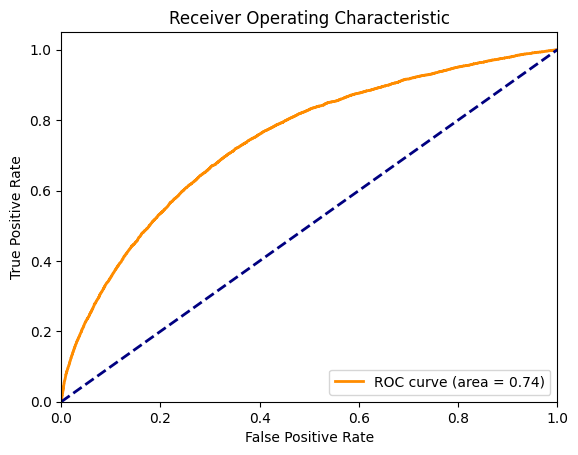

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have collected all_scores and all_labels from your dataset
pairs_labels_file_roc = '/project/msoleyma_1026/ecp-cause-pair/utterance_pairs_emotion_flags_train.json'
embeddings_dir_roc = '/project/msoleyma_1026/ecp-cause-pair/pair_embeddings/video-train'
train_dataset_roc = PairDataset(pairs_labels_file_roc, embeddings_dir_roc, mode='train')
train_loader_roc = DataLoader(train_dataset_roc, batch_size=batch_size, shuffle=True, collate_fn=debug_collate_fn)
scores, labels = evaluate_model_for_roc(model, train_loader_roc, device)

fpr, tpr, thresholds = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [20]:
# Calculate the optimal threshold: the one with the highest tpr - fpr
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print('Optimal threshold:', optimal_threshold)

Optimal threshold: 0.4782871901988983


In [21]:
import json
import torch
from torch.utils.data import DataLoader


def load_predicted_emotions(json_filepath):
    #print(f"Loading predicted emotions from {json_filepath}")
    with open(json_filepath, 'r') as file:
        data = json.load(file)
    predicted_emotions_dict = {}
    for conversation in data:
        conversation_id = str(conversation['conversation_id'])
        for utterance in conversation['utterances']:
            utterance_id = str(utterance['utt_id'])
            emotion = utterance['emotion']
            if conversation_id not in predicted_emotions_dict:
                predicted_emotions_dict[conversation_id] = {}
            predicted_emotions_dict[conversation_id][utterance_id] = emotion
    #print("Predicted Emotions Loaded")
    return predicted_emotions_dict

def load_true_emotions(json_filepath):
    #print(f"Loading true emotions from {json_filepath}")
    with open(json_filepath, 'r') as file:
        data = json.load(file) 
    true_emotions_dict = {}
    for conversation_data in data:  
        for conversation_id, utterance_pairs in conversation_data.items():
            if conversation_id not in true_emotions_dict:
                true_emotions_dict[conversation_id] = {}
            for utterance_info in utterance_pairs:
                utterance_pair = utterance_info['utterance_pair']
                emotion = utterance_info['emotion']
                first_utterance_id = str(utterance_pair[0])  # First element of the utterance pair
                true_emotions_dict[conversation_id][first_utterance_id] = emotion
    #print("True Emotions Loaded")
    return true_emotions_dict

def filter_predicted_emotions(predicted_emotions_dict, true_emotions_dict):
    filtered_dict = {}
    for conv_id, utterances in predicted_emotions_dict.items():
        if conv_id in true_emotions_dict:
            filtered_dict[conv_id] = {}
            for utt_id in utterances:
                if utt_id in true_emotions_dict[conv_id]:
                    filtered_dict[conv_id][utt_id] = predicted_emotions_dict[conv_id][utt_id]
    return filtered_dict

from sklearn.preprocessing import LabelEncoder

def encode_emotions(emotions_dict):
    encoder = LabelEncoder()
    emotion_labels = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
    encoder.fit(emotion_labels)
    encoded_dict = {}
    for conv_id, utterances in emotions_dict.items():#
        encoded_dict[conv_id] = {}
        for utt_id, emotion in utterances.items():
            if emotion in emotion_labels:  # Only encode if the emotion is known
                encoded_dict[conv_id][utt_id] = encoder.transform([emotion])[0]
            else:
                encoded_dict[conv_id][utt_id] = -1  # Encode unknown emotions as -1
    return encoded_dict

def compare_emotion_accuracy(predicted_emotions_dict, true_emotions_dict):
    total_emotions_checked = 0
    total_emotions_matched = 0
    mismatched_emotions = []
    mismatches = []

    # Iterate over the true emotions dictionary
    for conv_id, utterances in true_emotions_dict.items():
        for utt_id, true_emotion in utterances.items():
            # Check if this utterance is also in the predicted emotions dictionary
            if conv_id in predicted_emotions_dict and utt_id in predicted_emotions_dict[conv_id]:
                predicted_emotion = predicted_emotions_dict[conv_id][utt_id]
                total_emotions_checked += 1
                if true_emotion == predicted_emotion:
                    total_emotions_matched += 1
                else:
                    if conv_id not in mismatches:
                        mismatches.append({
                                'conversation_id' : int(conv_id),
                                'utterance_id' : int(utt_id),
                                'predicted_emotion' : int(predicted_emotion),
                                'true_emotion' : int(true_emotion)
                            })
                    mismatched_emotions.append((conv_id, utt_id, true_emotion, predicted_emotion))

    mismatch_file_path = "/project/msoleyma_1026/ecp-cause-pair/json_files/mismatch_pair_late_video.json"
    with open(mismatch_file_path, 'w') as f:
        json.dump(mismatches, f, indent=4)
    accuracy = total_emotions_matched / total_emotions_checked if total_emotions_checked > 0 else 0
    return accuracy, mismatched_emotions

def check_emotion_match(predicted_emotions_dict, true_emotions_dict, conv_id, utt_id):

    conv_id = str(conv_id)
    utt_id = str(utt_id)
    if conv_id in predicted_emotions_dict and utt_id in predicted_emotions_dict[conv_id]:
        predicted_emotion = predicted_emotions_dict[conv_id][utt_id]
        if conv_id in true_emotions_dict and utt_id in true_emotions_dict[conv_id]:
            true_emotion = true_emotions_dict[conv_id][utt_id]

            if true_emotion == predicted_emotion:
                return True,predicted_emotion,true_emotion
            else:
                return False,predicted_emotion,true_emotion
        else:
            return False,predicted_emotion, None
    else:
        return False,None,None

In [28]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    predictions = {}
    detailed_results = {}  # Initialize the dictionary at the beginning of the function
    correct_pair = 0
    combined_TP = 0
    combined_FP = 0
    combined_FN = 0
    combined_TN = 0
    true_emotions_dict = load_true_emotions('/project/msoleyma_1026/ecp-cause-pair/utterance_pairs_emotion_flags_test.json')
    true_emotions_encoded = encode_emotions(true_emotions_dict)
    predicted_emotions_dict = load_predicted_emotions('/project/msoleyma_1026/ecp-cause-pair/predictions/late_fusion_predictions_all.json')


    TP = 0
    FP = 0
    FN = 0
    TN = 0

    with torch.no_grad():
        for batch in dataloader:
            context_embeddings, target_pairs, conversation_ids, utterance_ids = batch
            
            context_embeddings = context_embeddings.to(device)
            target_pairs = target_pairs.to(device)
            # print(f"Target pairs shape: {target_pairs.shape}")
            
            output = model(context_embeddings)
            # print(f"Output shape: {output.shape}")

            target_pairs = target_pairs.squeeze()
            # print(f"Target pairs shape after squeeze(): {target_pairs.shape}")
            
            active_outputs = output[target_pairs != -1]
            # print(f"Active outputs shape: {active_outputs.shape}")
            active_pairs = target_pairs[target_pairs != -1]
            loss = criterion(active_outputs, active_pairs)

            total_loss += loss.item()
            sigmoid_output = torch.sigmoid(active_outputs)
            # print(f"Sigmoid output shape: {sigmoid_output.shape}")

            threshold = optimal_threshold #calculated using ROC
            # threshold = 0.5
            binary_predictions = (sigmoid_output >= threshold).float()
            # print(f"Binary predictions shape: {binary_predictions.shape}")
            # print(f"Target pairs shape: {target_pairs.shape}")
            correct_predictions = (binary_predictions == active_pairs)
            # correct_predictions = correct_predictions[target_pairs != -1]
            
            total_correct += correct_predictions.sum().item()
            total_samples += active_pairs.size(0)

            # Calculate TP, FP, FN
            TP += ((binary_predictions == 1) & (active_pairs == 1)).sum().item()
            FP += ((binary_predictions == 1) & (active_pairs == 0)).sum().item()
            FN += ((binary_predictions == 0) & (active_pairs == 1)).sum().item()
            TN += ((binary_predictions == 0) & (active_pairs == 0)).sum().item()


            prediction_tensor = binary_predictions
            true_tensor = active_pairs
            pair_flag = -1
            for conv_index, conv_id in enumerate(conversation_ids):
                utterances = utterance_ids[conv_index]
                for utterance_index, utterance in enumerate(utterances):
                    pair_flag +=1
                    match, predicted_emo, true_emo = check_emotion_match(predicted_emotions_dict,true_emotions_encoded,conv_id,utterance[0])
                    if(true_tensor[pair_flag]==prediction_tensor[pair_flag] and match):
                        correct_pair +=1
                    if (match and true_tensor[pair_flag]==1 and prediction_tensor[pair_flag]==1):
                        combined_TP +=1
                    elif (match and prediction_tensor[pair_flag]==1 and true_tensor[pair_flag]==0):
                        combined_FP +=1
                    elif (match and prediction_tensor[pair_flag]==0 and true_tensor[pair_flag]==1):
                        combined_FN +=1
                    elif (match and prediction_tensor[pair_flag]==0 and true_tensor[pair_flag]==0):
                        combined_TN +=1
                    
 
    print(f"True Positives: {TP}")
    print(f"False Positives: {FP}")
    print(f"False Negatives: {FN}")
    print(f"True Negatives: {TN}")
    print(f"Total samples: {total_samples}")

    print(f"Combined True Positives: {combined_TP}")
    print(f"Combined False Positives: {combined_FP}")
    print(f"Combined False Negatives: {combined_FN}")
    print(f"Combined True Negatives: {combined_TN}")
    print(f"Total samples: {total_samples}")

    average_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_samples
    combined_accuracy = correct_pair/total_samples
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    combined_precision = combined_TP / (combined_TP + combined_FP) if (combined_TP + combined_FP) > 0 else 0
    combined_recall = combined_TP / (combined_TP + combined_FN) if (combined_TP + combined_FN) > 0 else 0
    combined_f1_score = 2 * (combined_precision * combined_recall) / (combined_precision + combined_recall) if (combined_precision + combined_recall) > 0 else 0

    print(f"Combined Precision: {combined_precision:.4f}, Combined Recall: {combined_recall:.4f}, Combined F1-Score: {combined_f1_score:.4f}")
    
    return average_loss, accuracy, precision, recall, f1_score, combined_accuracy

In [29]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pairs_labels_file = '/project/msoleyma_1026/ecp-cause-pair/utterance_pairs_emotion_flags_test.json'
embeddings_dir = '/project/msoleyma_1026/ecp-cause-pair/pair_embeddings/video-test'

test_dataset = PairDataset(pairs_labels_file, embeddings_dir, mode='eval')

test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=debug_collate_fn)

val_loss, val_accuracy, val_precision, val_recall, val_f1_score,val_accuracy = evaluate_model(model, test_dataloader, criterion)
print(f'Test Loss: {val_loss:.4f}, Test Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1_score:.4f}, Combined Accuracy Score: {val_accuracy:.4f}')

True Positives: 1498
False Positives: 4813
False Negatives: 295
True Negatives: 3726
Total samples: 10332
Combined True Positives: 326
Combined False Positives: 958
Combined False Negatives: 60
Combined True Negatives: 605
Total samples: 10332
Combined Precision: 0.2539, Combined Recall: 0.8446, Combined F1-Score: 0.3904
Test Loss: 0.9934, Test Accuracy: 0.0901, Precision: 0.2374, Recall: 0.8355, F1 Score: 0.3697, Combined Accuracy Score: 0.0901


For pos_w: 4.8


/project/msoleyma_1026/ecp-cause-pair/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.1927
Epoch [1/20], Batch [10/17], Loss: 1.1317
Epoch [1/20], Batch [15/17], Loss: 1.1273
Epoch 1/20, Loss: 1.1494
Epoch [2/20], Batch [5/17], Loss: 1.1411
Epoch [2/20], Batch [10/17], Loss: 1.0410
Epoch [2/20], Batch [15/17], Loss: 1.0732
Epoch 2/20, Loss: 1.1185
Epoch [3/20], Batch [5/17], Loss: 1.0984
Epoch [3/20], Batch [10/17], Loss: 1.1403
Epoch [3/20], Batch [15/17], Loss: 1.1264
Epoch 3/20, Loss: 1.1172
Epoch [4/20], Batch [5/17], Loss: 1.1235
Epoch [4/20], Batch [10/17], Loss: 1.0991
Epoch [4/20], Batch [15/17], Loss: 1.1451
Epoch 4/20, Loss: 1.1154
Epoch [5/20], Batch [5/17], Loss: 1.0527
Epoch [5/20], Batch [10/17], Loss: 1.0824
Epoch [5/20], Batch [15/17], Loss: 1.1253
Epoch 5/20, Loss: 1.1141
Epoch [6/20], Batch [5/17], Loss: 1.1303
Epoch [6/20], Batch [10/17], Loss: 1.0910
Epoch [6/20], Batch [15/17], Loss: 1.0804
Epoch 6/20, Loss: 1.1088
Epoch [7/20], Batch [5/17], Loss: 1.1200
Epoch [7/20], Batch [10/17], Loss: 1.1147
Epoch [7/20], Bat

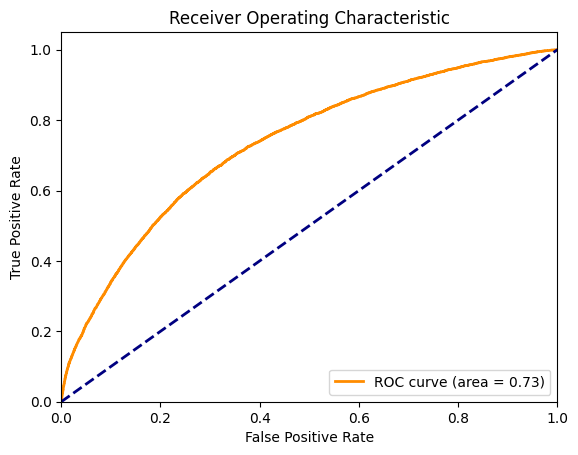

Optimal threshold: 0.49341171979904175
True Positives: 1440
False Positives: 4353
False Negatives: 353
True Negatives: 4186
Total samples: 10332
For pos_weight: 4.8 ---> Test Loss: 1.0345, Test Accuracy: 0.5445, Precision: 0.2486, Recall: 0.8031, F1 Score: 0.3796
For pos_w: 4.7


/project/msoleyma_1026/ecp-cause-pair/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.2843
Epoch [1/20], Batch [10/17], Loss: 1.1072
Epoch [1/20], Batch [15/17], Loss: 1.1463
Epoch 1/20, Loss: 1.1853
Epoch [2/20], Batch [5/17], Loss: 1.0990
Epoch [2/20], Batch [10/17], Loss: 1.1227
Epoch [2/20], Batch [15/17], Loss: 1.1101
Epoch 2/20, Loss: 1.1049
Epoch [3/20], Batch [5/17], Loss: 1.1278
Epoch [3/20], Batch [10/17], Loss: 1.0480
Epoch [3/20], Batch [15/17], Loss: 1.0878
Epoch 3/20, Loss: 1.1078
Epoch [4/20], Batch [5/17], Loss: 1.1516
Epoch [4/20], Batch [10/17], Loss: 1.1618
Epoch [4/20], Batch [15/17], Loss: 1.0512
Epoch 4/20, Loss: 1.0985
Epoch [5/20], Batch [5/17], Loss: 1.0691
Epoch [5/20], Batch [10/17], Loss: 1.1950
Epoch [5/20], Batch [15/17], Loss: 1.1134
Epoch 5/20, Loss: 1.1003
Epoch [6/20], Batch [5/17], Loss: 1.1252
Epoch [6/20], Batch [10/17], Loss: 1.1114
Epoch [6/20], Batch [15/17], Loss: 1.0637
Epoch 6/20, Loss: 1.1008
Epoch [7/20], Batch [5/17], Loss: 1.0550
Epoch [7/20], Batch [10/17], Loss: 1.0937
Epoch [7/20], Bat

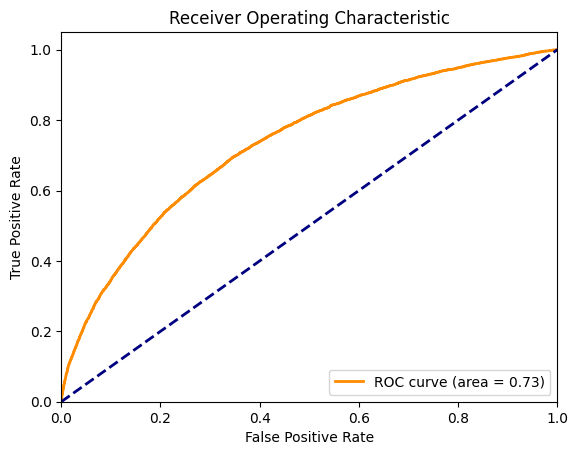

Optimal threshold: 0.5018022656440735
True Positives: 1447
False Positives: 4505
False Negatives: 346
True Negatives: 4034
Total samples: 10332
For pos_weight: 4.7 ---> Test Loss: 1.0327, Test Accuracy: 0.5305, Precision: 0.2431, Recall: 0.8070, F1 Score: 0.3737
For pos_w: 4.6


/project/msoleyma_1026/ecp-cause-pair/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.1851
Epoch [1/20], Batch [10/17], Loss: 1.0788
Epoch [1/20], Batch [15/17], Loss: 1.1491
Epoch 1/20, Loss: 1.1218
Epoch [2/20], Batch [5/17], Loss: 1.0940
Epoch [2/20], Batch [10/17], Loss: 1.1408
Epoch [2/20], Batch [15/17], Loss: 1.0921
Epoch 2/20, Loss: 1.0992
Epoch [3/20], Batch [5/17], Loss: 1.1235
Epoch [3/20], Batch [10/17], Loss: 1.0919
Epoch [3/20], Batch [15/17], Loss: 1.1126
Epoch 3/20, Loss: 1.0991
Epoch [4/20], Batch [5/17], Loss: 1.0179
Epoch [4/20], Batch [10/17], Loss: 1.0881
Epoch [4/20], Batch [15/17], Loss: 1.1010
Epoch 4/20, Loss: 1.0907
Epoch [5/20], Batch [5/17], Loss: 1.1306
Epoch [5/20], Batch [10/17], Loss: 1.0796
Epoch [5/20], Batch [15/17], Loss: 1.0785
Epoch 5/20, Loss: 1.0914
Epoch [6/20], Batch [5/17], Loss: 1.0796
Epoch [6/20], Batch [10/17], Loss: 1.0886
Epoch [6/20], Batch [15/17], Loss: 1.0495
Epoch 6/20, Loss: 1.0901
Epoch [7/20], Batch [5/17], Loss: 1.0422
Epoch [7/20], Batch [10/17], Loss: 1.0672
Epoch [7/20], Bat

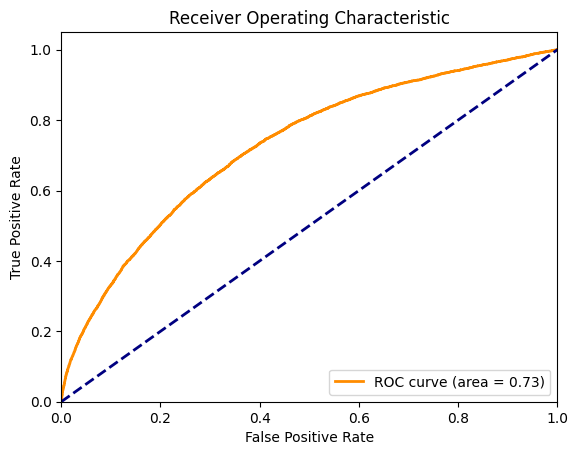

Optimal threshold: 0.48226505517959595
True Positives: 1491
False Positives: 4799
False Negatives: 302
True Negatives: 3740
Total samples: 10332
For pos_weight: 4.6 ---> Test Loss: 1.0355, Test Accuracy: 0.5063, Precision: 0.2370, Recall: 0.8316, F1 Score: 0.3689
For pos_w: 4.5


/project/msoleyma_1026/ecp-cause-pair/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.1452
Epoch [1/20], Batch [10/17], Loss: 1.1038
Epoch [1/20], Batch [15/17], Loss: 1.0826
Epoch 1/20, Loss: 1.1056
Epoch [2/20], Batch [5/17], Loss: 1.0581
Epoch [2/20], Batch [10/17], Loss: 1.1042
Epoch [2/20], Batch [15/17], Loss: 1.0741
Epoch 2/20, Loss: 1.0817
Epoch [3/20], Batch [5/17], Loss: 1.0932
Epoch [3/20], Batch [10/17], Loss: 1.1142
Epoch [3/20], Batch [15/17], Loss: 1.0628
Epoch 3/20, Loss: 1.0819
Epoch [4/20], Batch [5/17], Loss: 1.0705
Epoch [4/20], Batch [10/17], Loss: 1.1037
Epoch [4/20], Batch [15/17], Loss: 1.0606
Epoch 4/20, Loss: 1.0817
Epoch [5/20], Batch [5/17], Loss: 1.0804
Epoch [5/20], Batch [10/17], Loss: 1.0948
Epoch [5/20], Batch [15/17], Loss: 1.0668
Epoch 5/20, Loss: 1.0823
Epoch [6/20], Batch [5/17], Loss: 1.1215
Epoch [6/20], Batch [10/17], Loss: 1.0562
Epoch [6/20], Batch [15/17], Loss: 1.0428
Epoch 6/20, Loss: 1.0728
Epoch [7/20], Batch [5/17], Loss: 1.1150
Epoch [7/20], Batch [10/17], Loss: 1.0479
Epoch [7/20], Bat

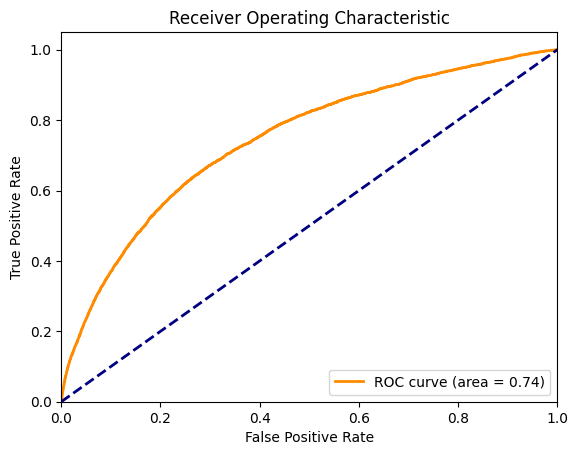

Optimal threshold: 0.4769313335418701
True Positives: 1495
False Positives: 4673
False Negatives: 298
True Negatives: 3866
Total samples: 10332
For pos_weight: 4.5 ---> Test Loss: 1.0003, Test Accuracy: 0.5189, Precision: 0.2424, Recall: 0.8338, F1 Score: 0.3756
For pos_w: 4.4


/project/msoleyma_1026/ecp-cause-pair/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.0704
Epoch [1/20], Batch [10/17], Loss: 1.1261
Epoch [1/20], Batch [15/17], Loss: 1.0642
Epoch 1/20, Loss: 1.0998
Epoch [2/20], Batch [5/17], Loss: 1.0653
Epoch [2/20], Batch [10/17], Loss: 1.1226
Epoch [2/20], Batch [15/17], Loss: 1.0580
Epoch 2/20, Loss: 1.0750
Epoch [3/20], Batch [5/17], Loss: 1.0543
Epoch [3/20], Batch [10/17], Loss: 1.0486
Epoch [3/20], Batch [15/17], Loss: 1.0900
Epoch 3/20, Loss: 1.0690
Epoch [4/20], Batch [5/17], Loss: 1.0186
Epoch [4/20], Batch [10/17], Loss: 1.0685
Epoch [4/20], Batch [15/17], Loss: 1.0730
Epoch 4/20, Loss: 1.0661
Epoch [5/20], Batch [5/17], Loss: 1.0518
Epoch [5/20], Batch [10/17], Loss: 1.0646
Epoch [5/20], Batch [15/17], Loss: 1.0758
Epoch 5/20, Loss: 1.0628
Epoch [6/20], Batch [5/17], Loss: 1.0703
Epoch [6/20], Batch [10/17], Loss: 1.0277
Epoch [6/20], Batch [15/17], Loss: 1.0742
Epoch 6/20, Loss: 1.0611
Epoch [7/20], Batch [5/17], Loss: 1.0887
Epoch [7/20], Batch [10/17], Loss: 1.0496
Epoch [7/20], Bat

KeyboardInterrupt: 

In [18]:
pos_ws = [4.8, 4.7, 4.6, 4.5, 4.4, 4.3, 4.2, 4.1, 4.0]
for pos_w in pos_ws:   
    print(f"For pos_w: {pos_w}") 
    input_size = 1543
    hidden_size = 1024
    num_classes = 1
    lr = 1e-5
    batch_size = 64
    num_epochs = 20
    num_layers = 4
    print_interval = 5

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    pairs_labels_file = '/project/msoleyma_1026/ecp-cause-pair/utterance_pairs_emotion_flags_train.json'
    embeddings_dir = '/project/msoleyma_1026/ecp-cause-pair/pair_embeddings/video-train'

    train_dataset = PairDataset(pairs_labels_file, embeddings_dir, mode='train')

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=debug_collate_fn)

    model = PairDetector(input_size, hidden_size, num_classes, n_layers=num_layers).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_w).float()) 

    total_loss = 0.0
    total_batches = 0

    for epoch in range(num_epochs):
        model.train()
        epoch_loss_emotion = 0.0
        num_batches = 0
        for batch_idx, (inputs, labels, convID, utterancePairs) in enumerate(train_loader):
            inputs = inputs.float()
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            labels = labels.squeeze()

            active_outputs = outputs[labels != -1]
            active_pairs = labels[labels != -1]
            loss = criterion(active_outputs, active_pairs)
            loss.backward()
            optimizer.step()

            epoch_loss_emotion += loss.item()
            total_loss += loss.item()
            total_batches += 1
            # print(loss.item())

            if (batch_idx + 1) % print_interval == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], '
                    f'Loss: {loss.item():.4f}')

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss_emotion / len(train_loader):.4f}")

    overall_avg_loss = total_loss / total_batches
    print(f"Overall Average Training Loss: {overall_avg_loss:.4f}")

    torch.save(model.state_dict(), '/project/msoleyma_1026/ecp-cause-pair/models/pair_detection_model_late_video.pt')

    
    scores, labels = evaluate_model_for_roc(model, train_loader_roc, device)

    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Calculate the optimal threshold: the one with the highest tpr - fpr
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print('Optimal threshold:', optimal_threshold)

    def evaluate_model(model, dataloader, criterion):
        model.eval()
        total_loss = 0.0
        total_correct = 0
        total_samples = 0

        TP = 0
        FP = 0
        FN = 0
        TN = 0

        with torch.no_grad():
            for batch in dataloader:
                context_embeddings, target_pairs, conversation_ids, utterance_ids = batch
                
                context_embeddings = context_embeddings.to(device)
                target_pairs = target_pairs.to(device)

                output = model(context_embeddings)

                target_pairs = target_pairs.squeeze()

                active_outputs = output[target_pairs != -1]
                active_pairs = target_pairs[target_pairs != -1]
                loss = criterion(active_outputs, active_pairs)

                total_loss += loss.item()
                sigmoid_output = torch.sigmoid(active_outputs)

                threshold = optimal_threshold #calculated using ROC
                # threshold = 0.5
                binary_predictions = (sigmoid_output >= threshold).float()

                correct_predictions = (binary_predictions == active_pairs)
                # correct_predictions = correct_predictions[target_pairs != -1]
                
                total_correct += correct_predictions.sum().item()
                total_samples += active_pairs.size(0)

                # Calculate TP, FP, FN
                TP += ((binary_predictions == 1) & (active_pairs == 1)).sum().item()
                FP += ((binary_predictions == 1) & (active_pairs == 0)).sum().item()
                FN += ((binary_predictions == 0) & (active_pairs == 1)).sum().item()
                TN += ((binary_predictions == 0) & (active_pairs == 0)).sum().item()

                # Store conversation and utterance IDs along with predicted emotions
                # for i in range(len(conversation_ids)):
                #     conv_id = conversation_ids[i]
                #     utter_id = utterance_ids[i]
                #     prediction = binary_predictions[i].tolist()
                #     predictions[(conv_id, utter_id)] = tuple(prediction)

        print(f"True Positives: {TP}")
        print(f"False Positives: {FP}")
        print(f"False Negatives: {FN}")
        print(f"True Negatives: {TN}")
        print(f"Total samples: {total_samples}")

        average_loss = total_loss / len(dataloader)
        accuracy = total_correct / total_samples

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        return average_loss, accuracy, precision, recall, f1_score

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    pairs_labels_file = '/project/msoleyma_1026/ecp-cause-pair/utterance_pairs_emotion_flags_test.json'
    embeddings_dir = '/project/msoleyma_1026/ecp-cause-pair/pair_embeddings/video-test'

    test_dataset = PairDataset(pairs_labels_file, embeddings_dir, mode='eval')

    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=debug_collate_fn)

    val_loss, val_accuracy, val_precision, val_recall, val_f1_score = evaluate_model(model, test_dataloader, criterion)
    print(f'For pos_weight: {pos_w} ---> Test Loss: {val_loss:.4f}, Test Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1_score:.4f}')

In [30]:
import json
import torch
from torch.utils.data import DataLoader


def load_predicted_emotions(json_filepath):
    #print(f"Loading predicted emotions from {json_filepath}")
    with open(json_filepath, 'r') as file:
        data = json.load(file)
    predicted_emotions_dict = {}
    for conversation in data:
        conversation_id = str(conversation['conversation_id'])
        for utterance in conversation['utterances']:
            utterance_id = str(utterance['utt_id'])
            emotion = utterance['emotion']
            if conversation_id not in predicted_emotions_dict:
                predicted_emotions_dict[conversation_id] = {}
            predicted_emotions_dict[conversation_id][utterance_id] = emotion
    #print("Predicted Emotions Loaded")
    return predicted_emotions_dict

def load_true_emotions(json_filepath):
    #print(f"Loading true emotions from {json_filepath}")
    with open(json_filepath, 'r') as file:
        data = json.load(file) 
    true_emotions_dict = {}
    for conversation_data in data:  
        for conversation_id, utterance_pairs in conversation_data.items():
            if conversation_id not in true_emotions_dict:
                true_emotions_dict[conversation_id] = {}
            for utterance_info in utterance_pairs:
                utterance_pair = utterance_info['utterance_pair']
                emotion = utterance_info['emotion']
                first_utterance_id = str(utterance_pair[0])  # First element of the utterance pair
                true_emotions_dict[conversation_id][first_utterance_id] = emotion
    #print("True Emotions Loaded")
    return true_emotions_dict

def filter_predicted_emotions(predicted_emotions_dict, true_emotions_dict):
    filtered_dict = {}
    for conv_id, utterances in predicted_emotions_dict.items():
        if conv_id in true_emotions_dict:
            filtered_dict[conv_id] = {}
            for utt_id in utterances:
                if utt_id in true_emotions_dict[conv_id]:
                    filtered_dict[conv_id][utt_id] = predicted_emotions_dict[conv_id][utt_id]
    return filtered_dict

from sklearn.preprocessing import LabelEncoder

def encode_emotions(emotions_dict):
    encoder = LabelEncoder()
    emotion_labels = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
    encoder.fit(emotion_labels)
    encoded_dict = {}
    for conv_id, utterances in emotions_dict.items():#
        encoded_dict[conv_id] = {}
        for utt_id, emotion in utterances.items():
            if emotion in emotion_labels:  # Only encode if the emotion is known
                encoded_dict[conv_id][utt_id] = encoder.transform([emotion])[0]
            else:
                encoded_dict[conv_id][utt_id] = -1  # Encode unknown emotions as -1
    return encoded_dict

def compare_emotion_accuracy(predicted_emotions_dict, true_emotions_dict):
    total_emotions_checked = 0
    total_emotions_matched = 0
    mismatched_emotions = []
    mismatches = []

    # Iterate over the true emotions dictionary
    for conv_id, utterances in true_emotions_dict.items():
        for utt_id, true_emotion in utterances.items():
            # Check if this utterance is also in the predicted emotions dictionary
            if conv_id in predicted_emotions_dict and utt_id in predicted_emotions_dict[conv_id]:
                predicted_emotion = predicted_emotions_dict[conv_id][utt_id]
                total_emotions_checked += 1
                if true_emotion == predicted_emotion:
                    total_emotions_matched += 1
                else:
                    if conv_id not in mismatches:
                        mismatches.append({
                                'conversation_id' : int(conv_id),
                                'utterance_id' : int(utt_id),
                                'predicted_emotion' : int(predicted_emotion),
                                'true_emotion' : int(true_emotion)
                            })
                    mismatched_emotions.append((conv_id, utt_id, true_emotion, predicted_emotion))

    mismatch_file_path = "/project/msoleyma_1026/ecp-cause-pair/json_files/mismatch_pair_late_video.json"
    with open(mismatch_file_path, 'w') as f:
        json.dump(mismatches, f, indent=4)
    accuracy = total_emotions_matched / total_emotions_checked if total_emotions_checked > 0 else 0
    return accuracy, mismatched_emotions

def check_emotion_match(predicted_emotions_dict, true_emotions_dict, conv_id, utt_id):

    conv_id = str(conv_id)
    utt_id = str(utt_id)
    if conv_id in predicted_emotions_dict and utt_id in predicted_emotions_dict[conv_id]:
        predicted_emotion = predicted_emotions_dict[conv_id][utt_id]
        if conv_id in true_emotions_dict and utt_id in true_emotions_dict[conv_id]:
            true_emotion = true_emotions_dict[conv_id][utt_id]

            if true_emotion == predicted_emotion:
                return True,predicted_emotion,true_emotion
            else:
                return False,predicted_emotion,true_emotion
        else:
            return False,predicted_emotion, None
    else:
        return False,None,None

In [31]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    predictions = {}
    detailed_results = {}  # Initialize the dictionary at the beginning of the function
    correct_pair = 0
    true_emotions_dict = load_true_emotions('/project/msoleyma_1026/ecp-cause-pair/utterance_pairs_emotion_flags_test.json')
    # Encode emotions
    true_emotions_encoded = encode_emotions(true_emotions_dict)
    # Load predicted emotions
    predicted_emotions_dict = load_predicted_emotions('/project/msoleyma_1026/ecp-cause-pair/predictions/late_fusion_predictions_video.json')


    with torch.no_grad():
        for batch_index, batch in enumerate(dataloader):
            context_embeddings, target_pairs, conversation_ids, utterance_ids = batch
            
            #print(f"Batch {batch_index} - context_embeddings shape: {context_embeddings.shape}")
            #print(f"Batch {batch_index} - target_pairs shape before squeeze: {target_pairs.shape}")
            
            context_embeddings = context_embeddings.to(device)
            target_pairs = target_pairs.to(device)

            output = model(context_embeddings)
            #print(f"Batch {batch_index} - Model output: {output.tolist()}")  # Printing the raw model output
            #print(f"Batch {batch_index} - Model output shape: {output.shape}")

            target_pairs = target_pairs.squeeze()
            #print(f"Batch {batch_index} - Target pairs (after squeeze): {target_pairs.tolist()}")  # Print all target pairs
            #print(f"Batch {batch_index} - target_pairs shape after squeeze: {target_pairs.shape}")

            active_outputs = output[target_pairs != -1]
            active_pairs = target_pairs[target_pairs != -1]
            #print(f"Batch {batch_index} - Active outputs: {active_outputs.tolist()}")  # Active model outputs
            #print(f"Batch {batch_index} - Active pairs: {active_pairs.tolist()}")  # Active target pairs
            #print(f"Batch {batch_index} - Active outputs shape: {active_outputs.shape}")
            #print(f"Batch {batch_index} - Active pairs shape: {active_pairs.shape}")

            loss = criterion(active_outputs, active_pairs)
            total_loss += loss.item()
            #print(f"Batch {batch_index} - Loss: {loss.item()}")

            sigmoid_output = torch.sigmoid(output)
            #print(f"Batch {batch_index} - Sigmoid output shape: {sigmoid_output.shape}")

            threshold = 0.5
            binary_predictions = (sigmoid_output >= threshold).float()
            #print(f"Batch {batch_index} - Binary predictions shape: {binary_predictions.shape}")

            correct_predictions = (binary_predictions == target_pairs)
            correct_predictions = correct_predictions[target_pairs != -1]
            total_correct += correct_predictions.sum().item()
            total_samples += active_pairs.size(0)

            # print(f"Batch {batch_index} - Correct Predictions: {correct_predictions.sum().item()} / {active_pairs.size(0)}")
            # print(f"Batch {batch_index} - Total Correct Predictions so far: {total_correct}")
            # print(f"Batch {batch_index} - Total Samples so far: {total_samples}")
            # print(f"Batch {batch_index} - Active pairs check: {active_pairs}")  # Active target pairs
            # print(f"Batch {batch_index} - Active pairs shape: {active_pairs.shape}")
            # print(f"Batch {batch_index} - Predictions check: {binary_predictions[target_pairs != -1]}")
            # print(f"Batch {batch_index} - predictions shape: {binary_predictions[target_pairs != -1].shape}")
            # print(f"Batch {batch_index} - conversation_ids: {conversation_ids}")
            prediction_tensor = binary_predictions[target_pairs != -1]
            true_tensor = active_pairs
            # print(f"Batch {batch_index} - true pairs check: {true_tensor.shape}")  # Active target pairs
            # print(f"Batch {batch_index} - prediction pairs check: {prediction_tensor.shape}")  # Active target pairs
            # print(f"Batch {batch_index} - true pairs check: {true_tensor}")  # Active target pairs
            # print(f"Batch {batch_index} - prediction pairs check: {prediction_tensor}")  # Active target pairs
            # print(f"Batch {batch_index} - conversation_ids shape: {len(conversation_ids)}")
            # print(f"Batch {batch_index} - utterance_id: {utterance_ids}")
            # Assuming each utterance_ids element is a list (list of lists scenario)
            # print(f"Batch {batch_index} - utterance_ids overall shape: {len(utterance_ids)}")
            # for i, utterance_list in enumerate(utterance_ids):
            #     print(f"Batch {batch_index} - utterance_id list {i} shape: {len(utterance_list)}")
            pair_flag = -1
            #correct_pair = 0
            for conv_index, conv_id in enumerate(conversation_ids):
                utterances = utterance_ids[conv_index]
                # print(f"Batch {batch_index} Conversation {conv_index} - Conversation_ID: {conv_id}")
                # print(f"Batch {batch_index} Conversation {conv_index} - Utterance IDs: {utterances}")
                for utterance_index, utterance in enumerate(utterances):
                    pair_flag +=1
                    # print(f"Batch {batch_index} Conversation {conv_index}, Utterance {utterance_index} - Utterance IDs: {utterance}, Pair Flag: {pair_flag}")
                    # print(f"Conversation Id: {type(conv_id).__name__}, Utterance Id {type(utterance[0]).__name__}")
                    # print(f"True Value {true_tensor[pair_flag]}, Predicted {prediction_tensor[pair_flag]}")
                    match, predicted_emo, true_emo = check_emotion_match(predicted_emotions_dict,true_emotions_encoded,conv_id,utterance[0])
                    # print(f"Match or Not {match}{predicted_emo}{true_emo}")
                    if(true_tensor[pair_flag]==prediction_tensor[pair_flag] and match):
                        #print("comparison successful")
                        correct_pair +=1
                    

    
    

            # for conv_id, utter_id, target, prediction in zip(conversation_ids, utterance_ids, active_pairs, binary_predictions):#[target_pairs !=1]):
            #     print(f"Batch {batch_index} - Conversation ID: {conv_id}, Utterance ID: {utter_id}")
            #     print(f"Batch {batch_index} - Target: {target}")
            #     print(f"Batch {batch_index} - Prediction: {prediction}")

    average_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_samples
    combined_accuracy = correct_pair/total_samples
    print(f"Final Average Loss: {average_loss}")
    print(f"Final Accuracy: {accuracy}")
    print(f"Combined Correct Predictions Accuracy: {correct_pair/total_samples}")

    return average_loss, accuracy, predictions,


In [37]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pairs_labels_file = '/project/msoleyma_1026/ecp-cause-pair/utterance_pairs_emotion_flags_test.json'
embeddings_dir = '/project/msoleyma_1026/ecp-cause-pair/pair_embeddings/video-test'

test_dataset = PairDataset(pairs_labels_file, embeddings_dir, mode='eval')

test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=debug_collate_fn)

true_emotions_dict = load_true_emotions('/project/msoleyma_1026/ecp-cause-pair/utterance_pairs_emotion_flags_test.json')
# Encode emotions
true_emotions_encoded = encode_emotions(true_emotions_dict)
# Load predicted emotions
predicted_emotions_dict = load_predicted_emotions('/project/msoleyma_1026/ecp-cause-pair/json_files/emo_predictions/late_fusion_predictions_video.json')
# Compare
accuracy, mismatches = compare_emotion_accuracy(predicted_emotions_dict, true_emotions_encoded)
print(f"Emotion Matching Accuracy: {accuracy*100:.2f}%")
if mismatches:
    print("Mismatched Emotions:")
    for mismatch in mismatches:
        print(f"Conversation ID: {mismatch[0]}, Utterance ID: {mismatch[1]}, True Emotion: {mismatch[2]}, Predicted Emotion: {mismatch[3]}")

val_loss, val_accuracy, val_predictions = evaluate_model(model, test_dataloader, criterion)
print(f'Validation Loss: {val_loss:.4f}, Test Accuracy: {val_accuracy:.4f}')

Emotion Matching Accuracy: 0.00%
Mismatched Emotions:
Conversation ID: 16, Utterance ID: 1, True Emotion: 6, Predicted Emotion: 4
Conversation ID: 16, Utterance ID: 4, True Emotion: 6, Predicted Emotion: 4
Conversation ID: 20, Utterance ID: 9, True Emotion: 3, Predicted Emotion: 4
Conversation ID: 20, Utterance ID: 10, True Emotion: 6, Predicted Emotion: 4
Conversation ID: 26, Utterance ID: 1, True Emotion: 0, Predicted Emotion: 4
Conversation ID: 26, Utterance ID: 2, True Emotion: 0, Predicted Emotion: 4
Conversation ID: 26, Utterance ID: 3, True Emotion: 5, Predicted Emotion: 4
Conversation ID: 26, Utterance ID: 5, True Emotion: 6, Predicted Emotion: 4
Conversation ID: 43, Utterance ID: 2, True Emotion: 5, Predicted Emotion: 4
Conversation ID: 43, Utterance ID: 3, True Emotion: 0, Predicted Emotion: 4
Conversation ID: 46, Utterance ID: 2, True Emotion: 0, Predicted Emotion: 4
Conversation ID: 46, Utterance ID: 3, True Emotion: 3, Predicted Emotion: 4
Conversation ID: 46, Utterance ID

In [38]:
import json
def load_json_data(filepath):
    with open(filepath, 'r') as file:
        data = json.load(file)
    return data

def convert_to_set(data):
    return {(int(d['conversation_id']), int(d['utterance_id']), int(d['predicted_emotion']), int(d['true_emotion'])) for d in data}

def compare_emotion_data(file1, file2):
    data1 = load_json_data(file1)
    data2 = load_json_data(file2)

    set1 = convert_to_set(data1)
    set2 = convert_to_set(data2)

    diff1 = set1 - set2
    diff2 = set2 - set1

    if not diff1 and not diff2:
        print("Both are identical")
    else:
        if diff1:
            print("in 1st not second")
        
        if diff2:
            print("in 2nd not in 1st")

file1_path = '/project/msoleyma_1026/ecp-cause-pair/json_files/mismatch_emo_late_video.json'
file2_path = '/project/msoleyma_1026/ecp-cause-pair/json_files/mismatch_pair_late_video.json'
compare_emotion_data(file1_path,file2_path)



Both are identical
